In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm

# JAX
import jax.numpy as jnp
from jax import random, jit
import time

# RELOADING MODULES
import importlib

# UTILS DIRECTORY
import sys
import os
collocation2_path = os.path.abspath(os.path.join('..', '00_utils'))

if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

# from collocation import compute_weights, lagrange_derivative

# processing
from scipy.interpolate import CubicSpline
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy.ndimage import gaussian_filter1d

import nn_jax_diffrax
importlib.reload(nn_jax_diffrax)
NeuralODE_JAX = nn_jax_diffrax.NeuralODE

In [180]:
data = pd.read_csv('df_train.csv')

data_subsample = data[data.settlement_date >= '2010-01-01']
# data_subsample = data_subsample[data_subsample.settlement_date < '2010-01-09']
data_subsample = data_subsample[:400]
data_subsample.reset_index(drop=True, inplace=True)

data_subsample['settlement_date'] = pd.to_datetime(data_subsample['settlement_date'])
data_subsample.loc[:,'hour'] = data_subsample['settlement_date'].dt.hour

# select the main columns for the intial testing
data_subsample = data_subsample[['settlement_date', 'temperature', 'hour', 'nd']]

print(f"The first/ last time points in the subsample are {np.min(data_subsample.settlement_date)}/ {np.max(data_subsample.settlement_date)}")
print(f"Covering {np.max(data_subsample['settlement_date'].dt.day) - np.min(data_subsample['settlement_date'].dt.day)} days")

t = jnp.linspace(0., 1., data_subsample.shape[0]) 

# How many points cover one day?   
one_day_map = (data_subsample['settlement_date'].dt.day == np.min(data_subsample['settlement_date'].dt.day))
n_pt_per_day = one_day_map.sum()
print(f"Number of points per day: {n_pt_per_day}")

one_day_offset = (1/data_subsample.shape[0]) * n_pt_per_day
print(f"Time offset needed for 1 day: {one_day_offset}")

data_subsample.rename(columns={'settlement_date': 'date', 'temperature': 'var1', 'hour':'var2', 'nd':'y'}, inplace=True)
data_subsample['t'] = t

The first/ last time points in the subsample are 2010-01-01 00:00:00/ 2010-01-09 07:30:00
Covering 8 days
Number of points per day: 48
Time offset needed for 1 day: 0.12


In [181]:
def preprocessing(data_subsample, tau, m):
    """

    Args:
        data_subsample (dataframe): dataframe containing the subsample of the data;
        expected column names are: 'y', 'date', 'var1', 'var2' ect.
        tau (float): number of points per lag
        m (int): number of lags
    """
    d = data_subsample.copy()   
    columns = data_subsample.columns
    if 't' not in columns:
        raise ValueError("The time column is not present in the dataframe")
    if 'y' not in columns:
        raise ValueError("The target column is not present in the dataframe")
    
    t, y = data_subsample['t'], data_subsample['y']
    
    #----------------------------- SMOOTHING -----------------------------#
    # SIGMA = 2
    # y = gaussian_filter1d(y, sigma = SIGMA)
    # d['y'] = y
    
    #--------------------------------- LAGS -----------------------------#
    for i in range(1, m+1):
        d[f'y_lag{i}'] = d['y'].shift(tau*i)
            
    # the first point that has the last lag available
    first_index = d[f'y_lag{i}'].index[~d[f'y_lag{i}'].isna()][0]

    # drop rows where time lags are not available
    d = d.iloc[first_index:]
    t = d['t'] # reload 't' after slicing 
        
    split = int(0.5 * len(t)) # 50/50 split
    t_train, t_test = t[:split], t[split:]

    print(f"Training data: {t_train.shape[0]} timepoints")
    print(f"Training data: {t_test.shape[0]} timepoints")
    
    #------------------------- INTERPOLATION FUNCTIONS ---------------------------#

    var_cols_map = ['var' in col for col in d.columns]
    var_cols = d.columns[var_cols_map]
    
    # 1. fit interpolation functions 
    # 2. geneate data
    # 3. save to a new dataframe
    
    interpolated_data_train = {}
    interpolated_data_test = {}
    
    # INDEPENDENT VARIABLES
    for var in var_cols:
        cs = CubicSpline(t, d[var])
        interpolated_data_train[var] = cs(t_train)
        interpolated_data_test[var] = cs(t_test)
        
    # DEPENDENT VARIABLES    
    cs_y = CubicSpline(t, d['y'])
    interpolated_data_train['y'] = cs_y(t_train)
    interpolated_data_test['y'] = cs_y(t_test)
    
    # LAGGED DEPENDENT VARIABLES
    for i in range(1, m+1):
        cs = CubicSpline(t, d[f'y_lag{i}'])
        interpolated_data_train[f'y_lag{i}'] = cs(t_train)
        # here we need some logic to reuse the data available from the training set
        interpolated_data_test[f'y_lag{i}'] = cs(t_test)
        # this gives the whole range, but we need to cut it off where the training data ends
        offset = tau*i # points are needed for the lag
        for p in range(offset, len(t_test)):
            interpolated_data_test[f'y_lag{i}'][p] = np.nan
        
    # TIME
    interpolated_data_train['t'] = t_train
    interpolated_data_test['t'] = t_test

    print(f"Training data: {t_train.shape[0]} timepoints after interpolation")
    
    df_train = pd.DataFrame(interpolated_data_train)
    df_test = pd.DataFrame(interpolated_data_test)

    #------------------------- SCALE ---------------------------#
    scaler = StandardScaler()
    
    columns_to_scale = df_train.columns.difference(['t'])
    df_train[columns_to_scale] = scaler.fit_transform(df_train[columns_to_scale])
    df_test[columns_to_scale] = scaler.transform(df_test[columns_to_scale])
    
    return df_train, df_test

In [ ]:
def preprocessing_offsets(data_subsample, tau, m):
    """

    Args:
        data_subsample (dataframe): dataframe containing the subsample of the data;
        expected column names are: 'y', 'date', 'var1', 'var2' ect.
        tau (float): number of points per lag
        m (int): number of lags
    """
    d = data_subsample.copy()   
    columns = data_subsample.columns
    if 't' not in columns:
        raise ValueError("The time column is not present in the dataframe")
    if 'y' not in columns:
        raise ValueError("The target column is not present in the dataframe")
    
    t, y = data_subsample['t'], data_subsample['y']
    
    #----------------------------- SMOOTHING -----------------------------#
    # SIGMA = 2
    # y = gaussian_filter1d(y, sigma = SIGMA)
    # d['y'] = y
    
    #--------------------------------- LAGS -----------------------------#
    for i in range(1, m+1):
        d[f'y_lag{i}'] = d['y'].shift(tau*i)
            
    # the first point that has the last lag available
    first_index = d[f'y_lag{i}'].index[~d[f'y_lag{i}'].isna()][0]

    # drop rows where time lags are not available
    d = d.iloc[first_index:]
    t = d['t'] # reload 't' after slicing 
        
    split = int(0.5 * len(t)) # 50/50 split
    t_train, t_test = t[:split], t[split:]

    print(f"Training data: {t_train.shape[0]} timepoints")
    print(f"Training data: {t_test.shape[0]} timepoints")
    
    #------------------------- INTERPOLATION FUNCTIONS ---------------------------#

    var_cols_map = ['var' in col for col in d.columns]
    var_cols = d.columns[var_cols_map]
    
    # 1. fit interpolation functions 
    # 2. geneate data
    # 3. save to a new dataframe
    
    interpolated_data_train = {}
    interpolated_data_test = {}
    
    # INDEPENDENT VARIABLES
    for var in var_cols:
        cs = CubicSpline(t, d[var])
        interpolated_data_train[var] = cs(t_train)
        interpolated_data_test[var] = cs(t_test)
        
    # DEPENDENT VARIABLES    
    cs_y = CubicSpline(t, d['y'])
    interpolated_data_train['y'] = cs_y(t_train)
    interpolated_data_test['y'] = cs_y(t_test)
    
    # LAGGED DEPENDENT VARIABLES
    for i in range(1, m+1):
        cs = CubicSpline(t, d[f'y_lag{i}'])
        interpolated_data_train[f'y_lag{i}'] = cs(t_train)
        # here we need some logic to reuse the data available from the training set
        interpolated_data_test[f'y_lag{i}'] = cs(t_test)
        # this gives the whole range, but we need to cut it off where the training data ends
        offset = tau*i # points are needed for the lag
        for p in range(offset, len(t_test)):
            interpolated_data_test[f'y_lag{i}'][p] = np.nan
        
    # TIME
    interpolated_data_train['t'] = t_train
    interpolated_data_test['t'] = t_test

    print(f"Training data: {t_train.shape[0]} timepoints after interpolation")
    
    df_train = pd.DataFrame(interpolated_data_train)
    df_test = pd.DataFrame(interpolated_data_test)

    #------------------------- SCALE ---------------------------#
    scaler = StandardScaler()
    
    columns_to_scale = df_train.columns.difference(['t'])
    df_train[columns_to_scale] = scaler.fit_transform(df_train[columns_to_scale])
    df_test[columns_to_scale] = scaler.transform(df_test[columns_to_scale])
    
    return df_train, df_test

In [182]:
df_train, df_test = preprocessing(data_subsample, 2, 3)

Training data: 197 timepoints
Training data: 197 timepoints
Training data: 197 timepoints after interpolation


In [183]:
df_train.head()

,var1,var2,y,y_lag1,y_lag2,y_lag3,t
0,0.484602,-1.196404,-0.924615,-0.743668,-0.473440,-0.457896,0.015038
1,0.422971,-1.196404,-1.092006,-0.791966,-0.607675,-0.426840,0.017544
2,0.361340,-1.052338,-1.239125,-0.921809,-0.743963,-0.472946,0.020050
3,0.299709,-1.052338,-1.326108,-1.089003,-0.792265,-0.607157,0.022556
4,0.238078,-0.908272,-1.400352,-1.235949,-0.922122,-0.743421,0.025063


In [184]:
df_train.to_csv('df_train_preprocessed.csv', index=False)

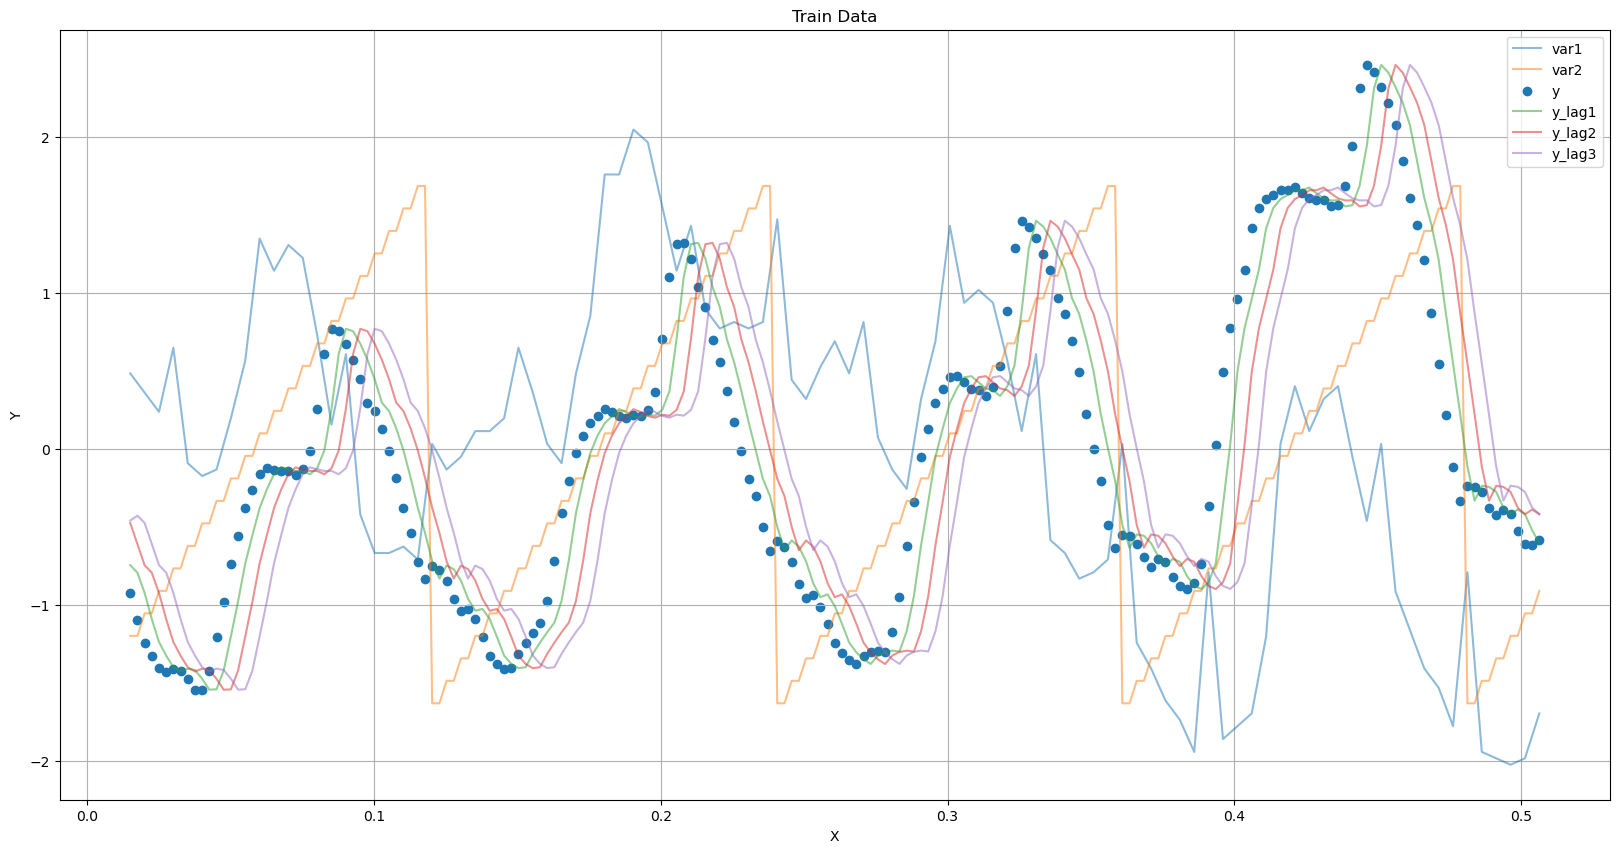

In [190]:
if True:
    plt.figure(figsize=(20, 10))
    
    for col in df_train.columns.difference(['t']):
        if col == 'y':
            plt.scatter(df_train['t'], df_train[col], label=col, alpha=1)
            continue
        plt.plot(df_train['t'], df_train[col], '-', label=col, alpha=0.5)
        
    #for col in df_test.columns.difference(['t']):
        #plt.plot(df_test['t'], df_test[col], '-', label=col, alpha=0.5)
    #plt.plot(t_train, y_train_scaled, '-', label='X_train_scaled', alpha=0.5)
    #plt.plot(x_train_cheb_lags, Xs[:,:2], 'b-', label='Dependent Variables', alpha=0.4, ls = '--')

    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Train Data')
    plt.grid(True)
    plt.show()

In [186]:
len(ys)

197

In [189]:
df_train.drop(columns=['y', 't'])

,var1,var2,y_lag1,y_lag2,y_lag3
0,0.484602,-1.196404,-0.743668,-0.473440,-0.457896
1,0.422971,-1.196404,-0.791966,-0.607675,-0.426840
2,0.361340,-1.052338,-0.921809,-0.743963,-0.472946
3,0.299709,-1.052338,-1.089003,-0.792265,-0.607157
4,0.238078,-0.908272,-1.235949,-0.922122,-0.743421
...,...,...,...,...,...
192,-2.021731,-1.196403,-0.417762,-0.274619,-0.235167
193,-2.001188,-1.196405,-0.387525,-0.375739,-0.242008
194,-1.980646,-1.052340,-0.416529,-0.418022,-0.274157
195,-1.836838,-1.052338,-0.519419,-0.387781,-0.375263


In [187]:
import nn_jax_diffrax
importlib.reload(nn_jax_diffrax)
NeuralODE_JAX = nn_jax_diffrax.NeuralODE

layer_widths = [6, 64, 64, 1]
learning_rate = 1e-3
rng = random.PRNGKey(42)

node_model = NeuralODE_JAX(layer_widths, time_invariant=True)

state = node_model.create_train_state(rng, learning_rate)

ys = jnp.atleast_2d(jnp.array(df_train['y'])).T
ts = jnp.array(df_train['t'])
Xs = jnp.array(df_train.drop(columns=['y', 't']))
extra_args = (Xs, ts)
y0 = jnp.array([ys[0]])

for k in [int(len(ys)*0.05), int(len(ys)*0.1), len(ys)]:
    state = node_model.train(state, ts[:k] 
                            , ys[:k], y0
                            , num_epochs = 10000
                            , extra_args = extra_args[:k]
                            )

Epoch 100, Loss: 8.10018539428711
Epoch 200, Loss: 6.660456657409668
Epoch 300, Loss: 6.08955192565918
Epoch 400, Loss: 5.8963751792907715
Epoch 500, Loss: 5.844048500061035
Epoch 600, Loss: 5.832900524139404
Epoch 700, Loss: 5.8310322761535645
Epoch 800, Loss: 5.830772876739502
Epoch 900, Loss: 5.830726623535156
Epoch 1000, Loss: 5.830700397491455
Epoch 1100, Loss: 5.830677509307861
Epoch 1200, Loss: 5.830653667449951
Epoch 1300, Loss: 5.83062744140625
Epoch 1400, Loss: 5.830594539642334
Epoch 1500, Loss: 5.830559253692627
Epoch 1600, Loss: 5.830507278442383
Epoch 1700, Loss: 5.830435276031494
Epoch 1800, Loss: 5.830227851867676
Epoch 1900, Loss: 5.793290615081787
Epoch 2000, Loss: 5.1772236824035645
Epoch 2100, Loss: 4.894137859344482
Epoch 2200, Loss: 4.763124942779541
Epoch 2300, Loss: 4.698974609375
Epoch 2400, Loss: 4.605467796325684
Epoch 2500, Loss: 4.542933940887451
Epoch 2600, Loss: 4.50391149520874
Epoch 2700, Loss: 4.4401726722717285
Epoch 2800, Loss: 4.4265360832214355
Epo

In [177]:
# reload
import nn_jax_diffrax
importlib.reload(nn_jax_diffrax)
NeuralODE_JAX = nn_jax_diffrax.NeuralODE
node_model = NeuralODE_JAX(layer_widths, time_invariant=True)

#  def neural_ode(self, params, y0, t, state, extra_args=None): 
y_train_pred = node_model.neural_ode(state.params, y0, ts, state, extra_args)

In [178]:
np.squeeze(y_train_pred).shape

(197,)

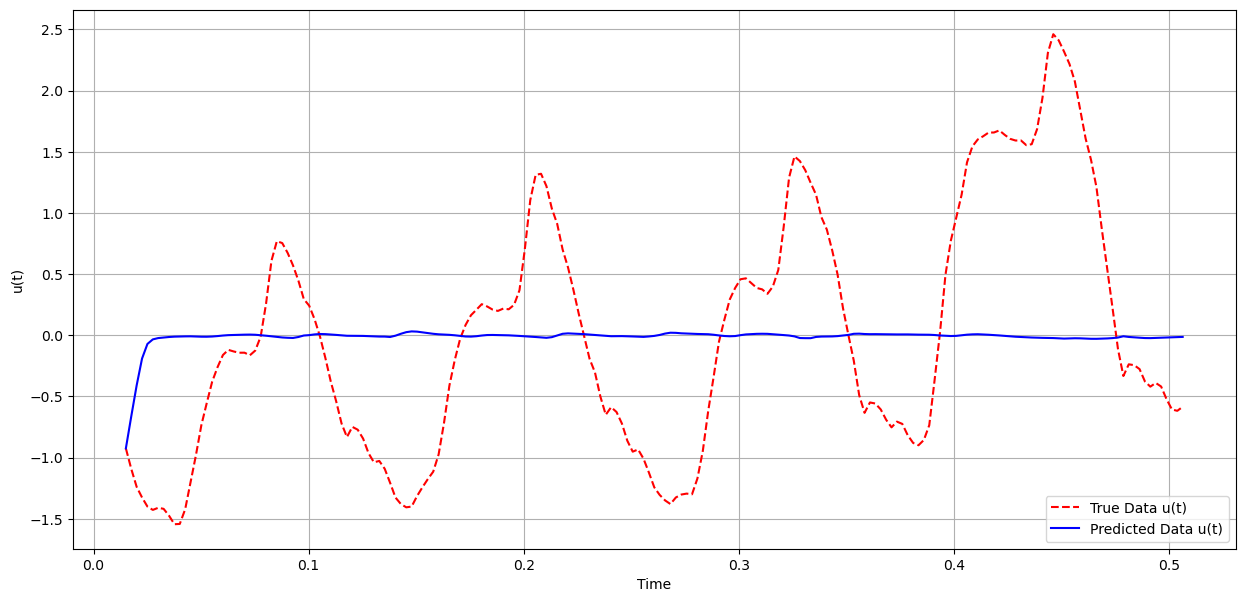

In [179]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))

plt.plot(ts, ys, 'r--', label='True Data u(t)')  
plt.plot(ts, np.squeeze(y_train_pred), 'b', label='Predicted Data u(t)') 

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()